In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import logging 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt

from brent.graph import DAG
from brent.query import Query
from brent.common import make_fake_df, normalise

# logging.basicConfig(
#     level=logging.DEBUG,
#     format='%(asctime)s [%(filename)s:%(funcName)s:%(lineno)d] %(levelname)s - %(message)s',
# )

In [3]:
df = pd.DataFrame({"a": [1, 1, 1, 1, 0, 0, 0, 0], 
                   "b": [0, 1, 0, 1, 1, 1, 1, 0], 
                   "c": [0, 0, 1, 0, 0, 1, 0, 1],
                   "d": [1, 1, 0, 1, 0, 0, 0, 0],
                   "e": [1, 1, 1, 1, 0, 0, 0, 0]})
dag = DAG(df).add_edge("a", "b").add_edge("a", "c").add_edge("c", "b")

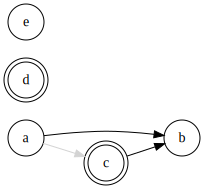

In [4]:
from graphviz import Digraph

def mkplot(dag, givens, dos):
    """A pretty plotting function."""
    d = Digraph()
    d.attr(rankdir='LR')
    d.attr('node', shape='circle')
    for n in dag.graph.nodes:
        if (n in givens) or (n in dos):
            d.node(n, shape='doublecircle')
        else:
            d.node(n)
    for n1, n2 in dag.graph.edges:
        if n2 in dos:
            d.edge(n1, n2, color="lightgray")
        else:
            d.edge(n1, n2)
    return d

mkplot(dag, givens=["d"], dos=["c"])

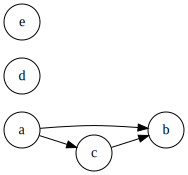

In [5]:
dag.plot()

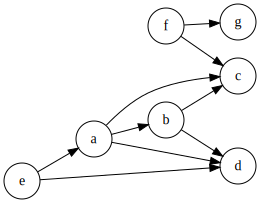

In [6]:
dag = (DAG(make_fake_df(7))
       .add_edge("e", "a")
       .add_edge("e", "d")
       .add_edge("a", "d")
       .add_edge("b", "d")
       .add_edge("a", "b")
       .add_edge("a", "c")
       .add_edge("b", "c")
       .add_edge("f", "c")
       .add_edge("f", "g"))

dag.plot()

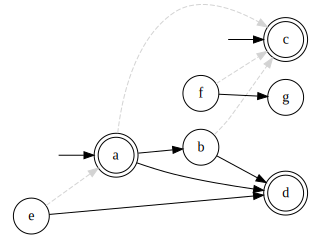

In [8]:
q = Query(dag).given(d=1).do(a=0, c=1)
q.plot()

In [9]:
q.infer()

{'f': {0: 0.43999999999999995, 1: 0.56},
 'e': {0: 0.4362781381982844, 1: 0.5637218618017155},
 'b': {0: 0.5507902642922454, 1: 0.4492097357077546},
 'a': {0: 1.0},
 'c': {1: 1.0},
 'g': {0: 0.45999999999999996, 1: 0.5399999999999999},
 'd': {1: 1.0}}

Next up: testing for independencies. 

In [10]:
import itertools as it 
import networkx as nx

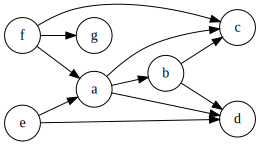

In [11]:
dag = (DAG(make_fake_df(7))
       .add_edge("e", "a")
       .add_edge("e", "d")
       .add_edge("a", "d")
       .add_edge("b", "d")
       .add_edge("a", "b")
       .add_edge("a", "c")
       .add_edge("b", "c")
       .add_edge("f", "c")
       .add_edge("f", "g")
       .add_edge("f", "a"))

dag.plot()

In [12]:
# logging.basicConfig(
#     level=logging.DEBUG,
#     format='%(asctime)s [%(filename)s:%(funcName)s:%(lineno)d] %(levelname)s - %(message)s',
# )

In [13]:
import itertools as it 

In [14]:
def conditional_independencies(dag, depth=1):
    for node_a, node_b in it.permutations(dag.nodes, 2):
        if len(dag.active_paths(node_a, node_b)) == 0:
            if node_a < node_b:
                print(f"{node_a}_||_{node_b}")
    
    for d in range(0, depth):
        for node_a, node_b, *given in it.permutations(dag.nodes, 2+d+1):
            if len(dag.active_paths(node_a, node_b, z=given)) == 0:
                if node_a < node_b:
                    if given == sorted(given):
                        print(f"{node_a}_||_{node_b} | {' '.join(given)}")

conditional_independencies(dag, depth=3)

e_||_f
e_||_g
a_||_g | f
b_||_e | a
b_||_f | a
b_||_g | a
b_||_g | f
c_||_g | f
d_||_g | f
e_||_f | b
e_||_f | g
e_||_g | b
e_||_g | f
a_||_g | b f
a_||_g | c f
a_||_g | d f
a_||_g | e f
b_||_e | a f
b_||_e | a g
b_||_f | a e
b_||_f | a g
b_||_g | a e
b_||_g | a f
b_||_g | c f
b_||_g | d f
b_||_g | e f
c_||_e | a f
c_||_g | a f
c_||_g | b f
c_||_g | d f
c_||_g | e f
d_||_f | a e
d_||_g | a e
d_||_g | a f
d_||_g | b f
d_||_g | c f
d_||_g | e f
e_||_f | b g
e_||_g | a f
e_||_g | b f
e_||_g | c f
e_||_g | d f
a_||_g | b c f
a_||_g | b d f
a_||_g | b e f
a_||_g | c d f
a_||_g | c e f
a_||_g | d e f
b_||_e | a c f
b_||_e | a f g
b_||_f | a d e
b_||_f | a e g
b_||_g | a c f
b_||_g | a d e
b_||_g | a d f
b_||_g | a e f
b_||_g | c d f
b_||_g | c e f
b_||_g | d e f
c_||_d | a b e
c_||_d | a b f
c_||_e | a b f
c_||_e | a f g
c_||_g | a b f
c_||_g | a d f
c_||_g | a e f
c_||_g | b d f
c_||_g | b e f
c_||_g | d e f
d_||_f | a b e
d_||_f | a e g
d_||_g | a b e
d_||_g | a b f
d_||_g | a c f
d_||_g |